# EEG Preprocessing

## Loading Data and Packages

๏ We start with a dataset that is already available in the MNE package (EEGBCI motor imagery dataset).

๏ The dataset contains 64-channel EEG recordings from 109 participants and 14 runs on each
participant in EDF+ format.

๏ In summary, the experimental runs were:

• Run1: Baseline, eyes open

• Run2: Baseline, eyes closed

• Run3: Task 1 (open and close left or right fist)

• Run4: Task 2 (imagine opening and closing left or right fist)

• Run5: Task 3 (open and close both fists or both feet)

• Run6: Task 4 (imagine opening and closing both fists or both feet)

• Run7: Task 1

• Run8: Task 2

• Run9: Task 3

• Run10: Task 4

• Run11: Task 1

• Run12: Task 2

• Run13: Task 3

• Run14: Task 4

๏ For more details please check https://mne.tools/stable/generated/
mne.datasets.eegbci.load_data.html#footcite-goldbergeretal2000

In [1]:
# Let's load some packages we need
import mne
import mne.viz
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import copy

#Load Dataset
subject = 1 # use data from subject 1
runs = [6, 10, 14] # use only hand and feet motor imagery runs

#Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
#Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
#Combine all loaded runs
raw_obj = concatenate_raws(raws)
raw_data = raw_obj._data

#Set Standard Channel Locations
eegbci.standardize(raw_obj) # set channel names
montage = make_standard_montage('standard_1005')
raw_obj.set_montage(montage)

#Extract events from raw data
events, event_ids = mne.events_from_annotations(raw_obj, event_id='auto')
tmin, tmax = -1, 4 # define epochs around events (in s)
#event_ids = dict(hands=2, feet=3) # map event IDs to tasks
epochs = mne.Epochs(raw_obj, events, event_ids, tmin - 0.5, tmax + 0.5, baseline=None, preload=True)

# Get sammpling frequency
fs=raw_obj.info['sfreq']

Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/joshua/Desktop/MainFolder/OuClasses/2024 Fall/Neural-Data-Science/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
90 ma

## Visual Inspection

Using matplotlib as 2D backend.


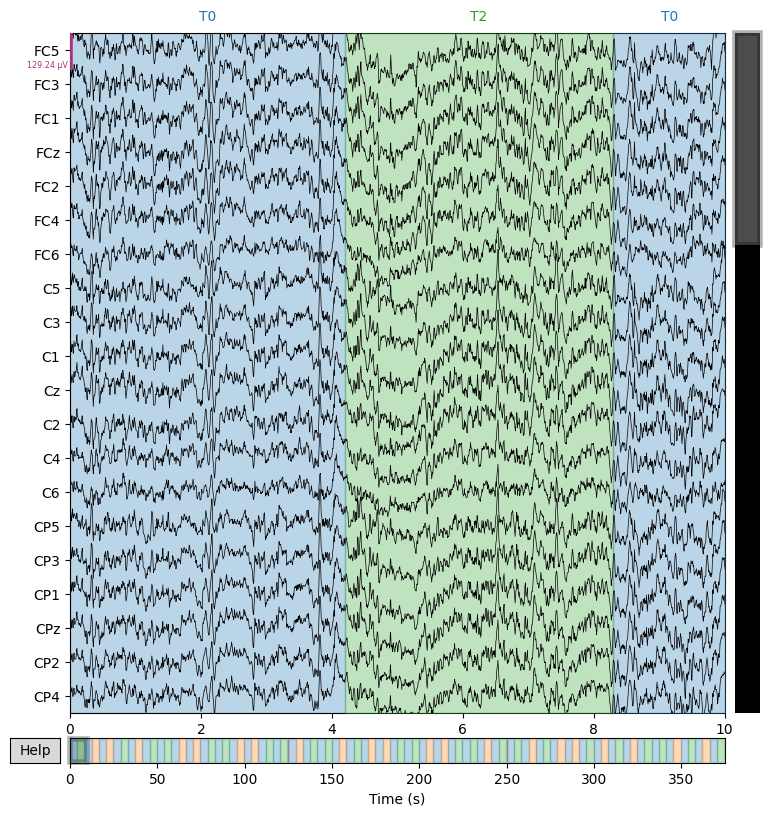

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


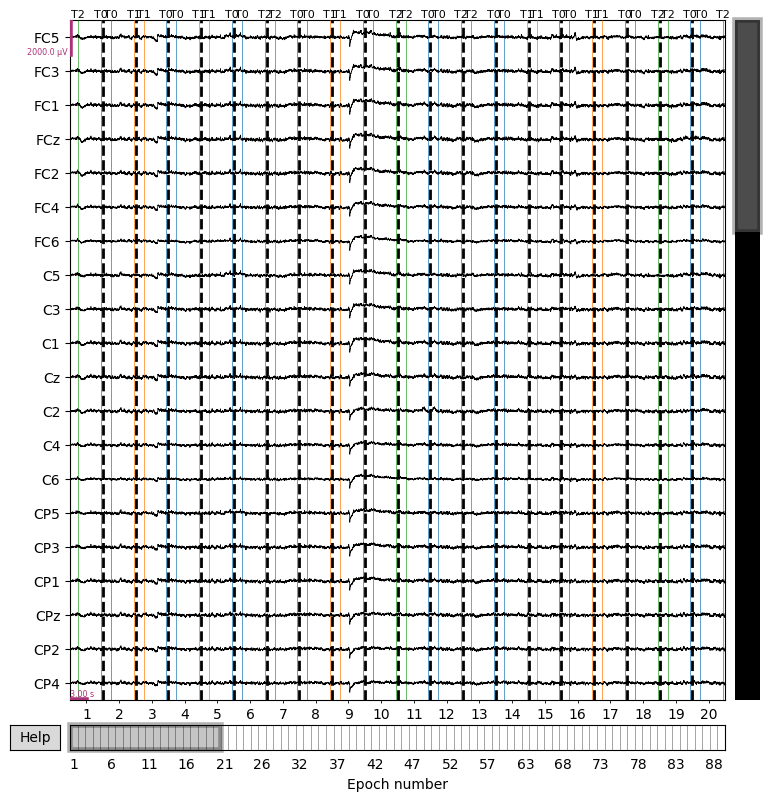

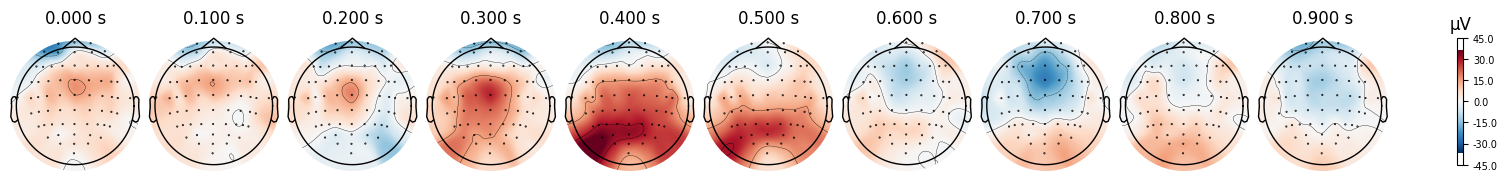

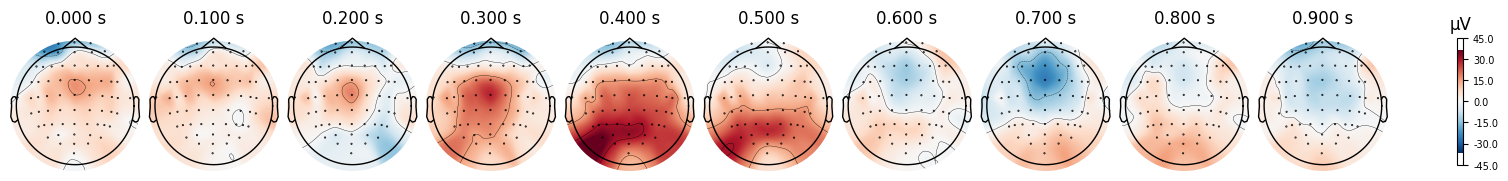

In [2]:
# Continuous Plot
raw_obj.plot(scalings='auto')
# Epoch Plot
epochs.plot(scalings=0.001, events=events,event_id=event_ids)
# Topomap
times = np.arange(0, 1, 0.1)
epochs.average().plot_topomap(times, ch_type='eeg')

Data from the eyes is processed through the back of the head, so that is probably what is going on here. We have to remove the EOC (eye version of EEG) noise.

## Re-Referencing

In [3]:
import copy

# create two copies of original epochs object for further comparison
copy_1_epochs = copy.deepcopy(epochs)
copy_2_epochs = copy.deepcopy(epochs)

# Re-reference by averaging
avg_ref_epochs = copy_1_epochs.set_eeg_reference('average', projection=True)

# Set a channel as the new reference
ch_ref_epochs = copy_2_epochs.set_eeg_reference(['TP8'])

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


Ploting the data and the reference

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


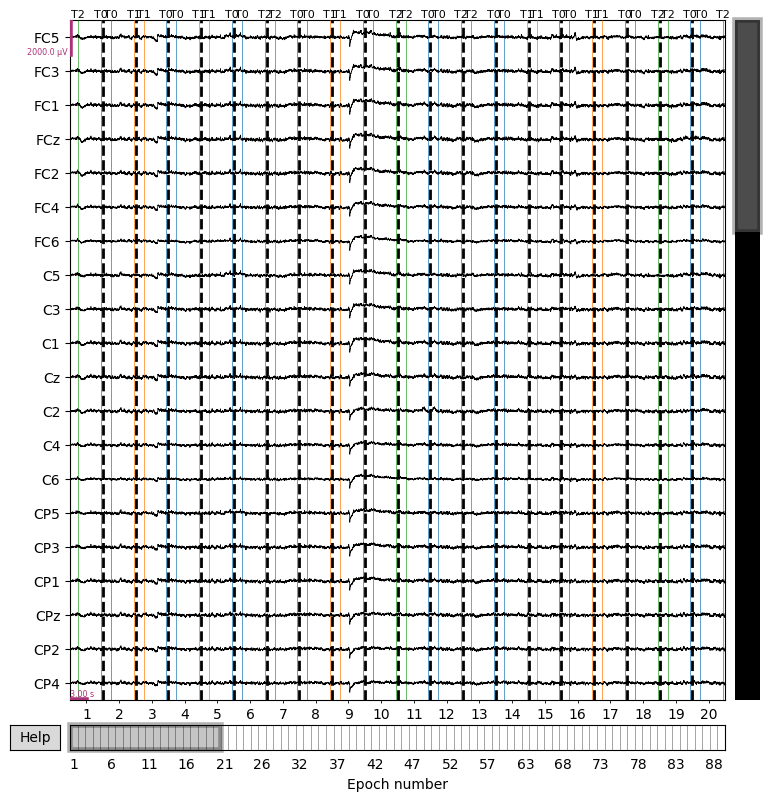

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


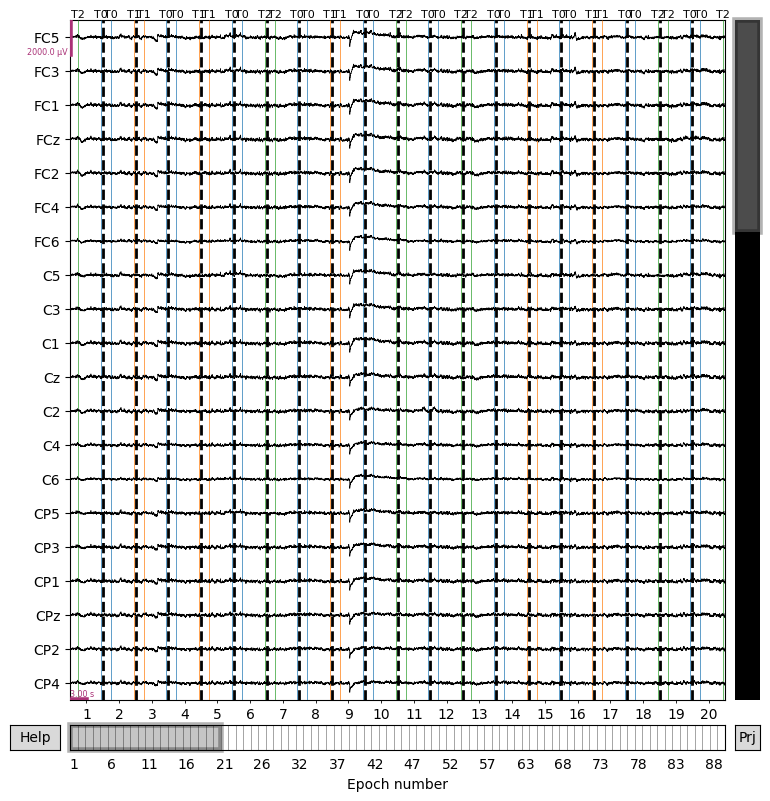

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


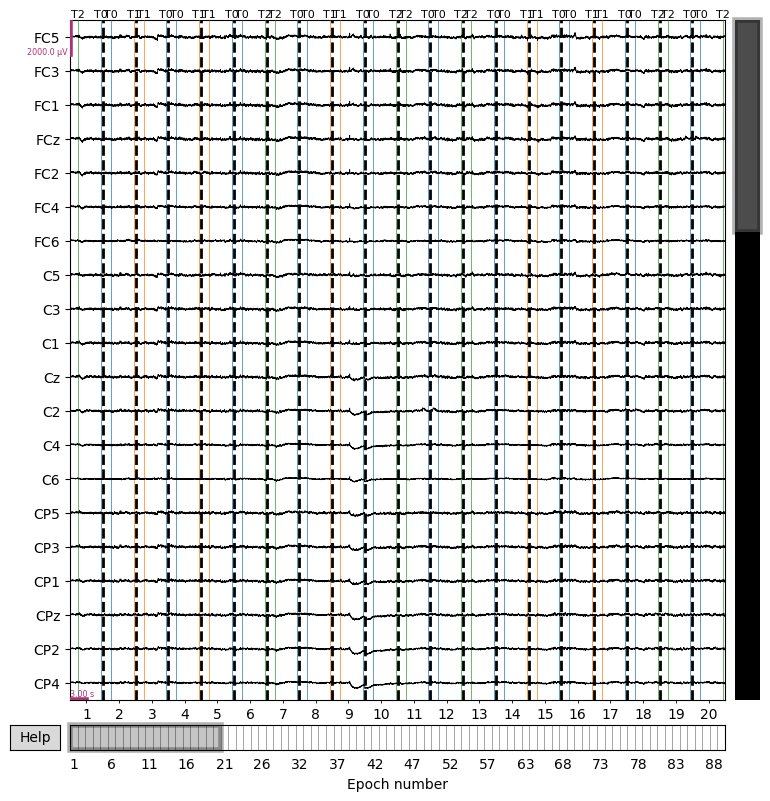

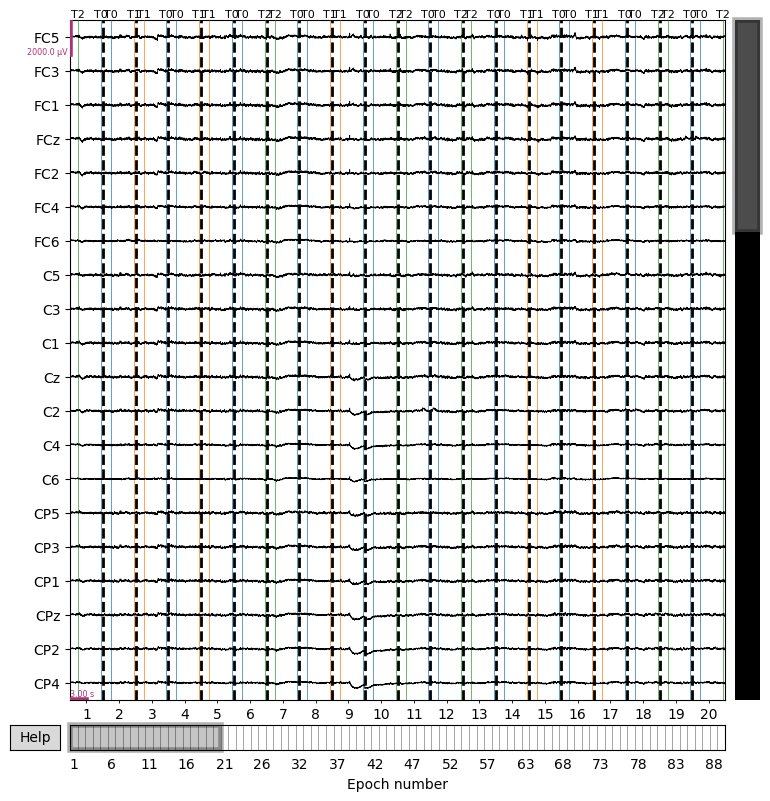

In [4]:
epochs.plot(scalings=0.001, events=events,event_id=event_ids)
avg_ref_epochs.plot(scalings=0.001, events=events,event_id=event_ids)
ch_ref_epochs.plot(scalings=0.001, events=events,event_id=event_ids)

## Digital Filtering

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/home/joshua/.local/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


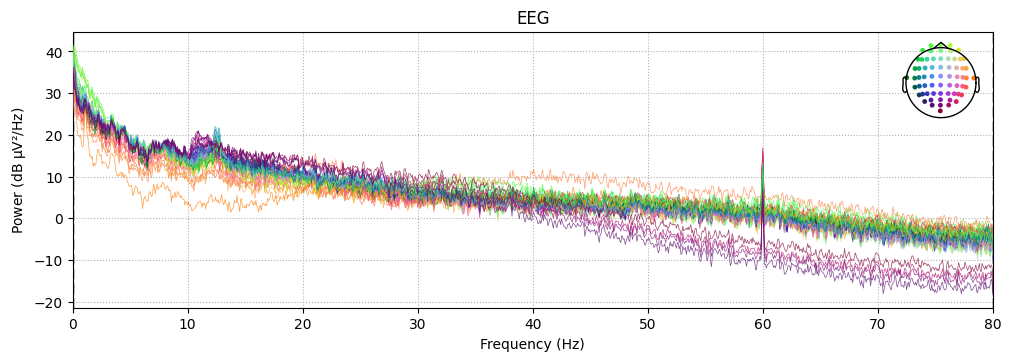

In [7]:
raw_obj.plot_psd()

To then filter out 60hz

Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/home/joshua/.local/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


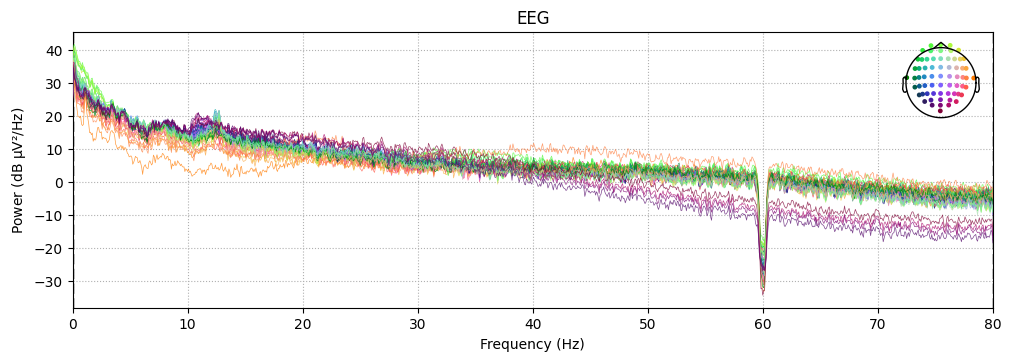

In [8]:
copy_rawobj_1 = copy.deepcopy(raw_obj)
copy_rawobj_1.notch_filter(freqs=60)
copy_rawobj_1.plot_psd()

## Low pass filtering

Filtering raw data in 3 contiguous segments
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/home/joshua/.local/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


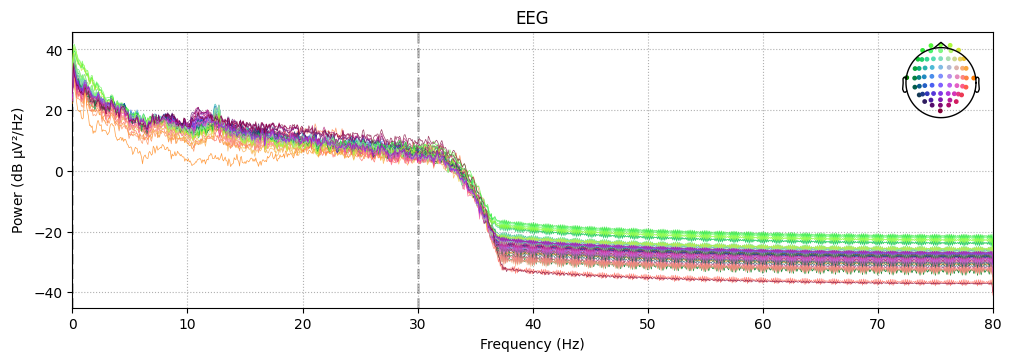

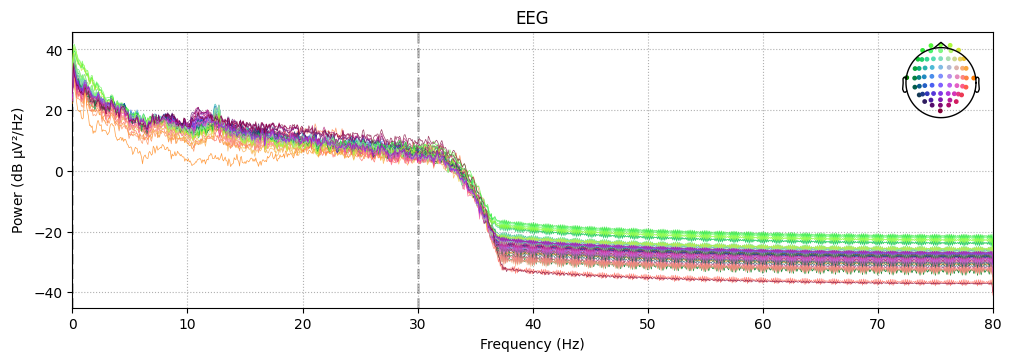

In [2]:
# low pass filtering below 30 Hz
low_pass_obj = copy.deepcopy(raw_obj)
low_pass_obj.filter(None, 30.)
low_pass_obj.plot_psd()

## High pass filtering

Filtering raw data in 3 contiguous segments
Setting up high-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00


- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Filter length: 213 samples (1.331 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Plotting power spectral density (dB=True).


/home/joshua/.local/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


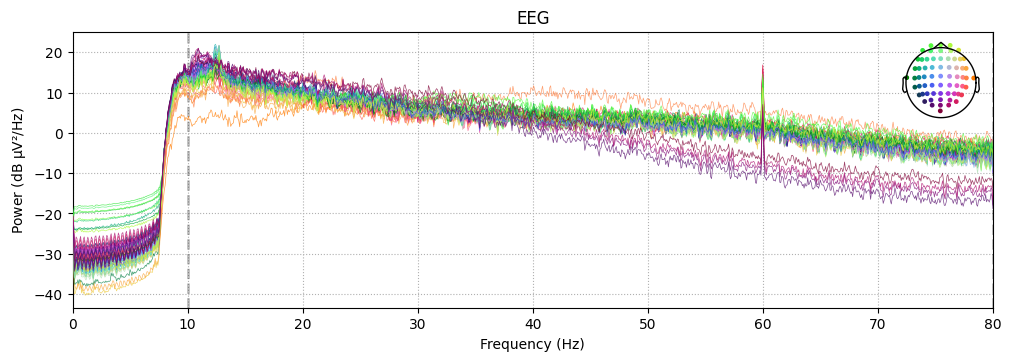

In [3]:
# High pass filtering above 10 Hz
high_pass_obj = copy.deepcopy(raw_obj)
high_pass_obj.filter(10., None)
high_pass_obj.plot_psd()

## Band-pass filter combines the two (High & Low pass)

## Notch filter removes a single frequency

---

## Downsampling

100.0
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


/home/joshua/.local/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


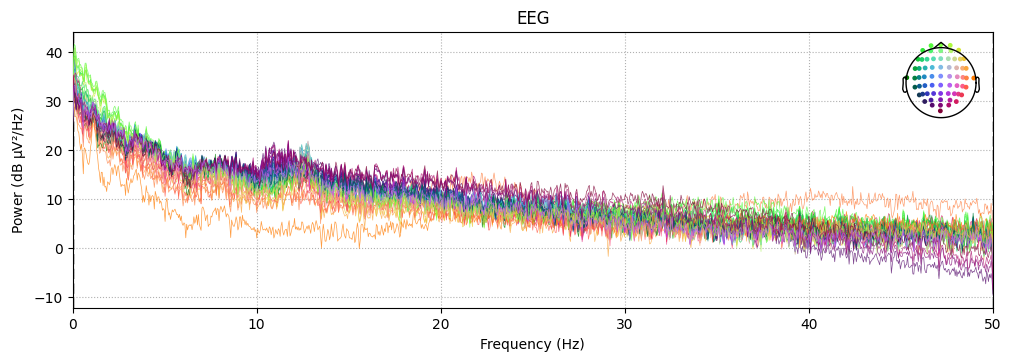

In [9]:
## Downsample Signal
orig_obj = copy.deepcopy(raw_obj)
len(orig_obj)
print(orig_obj.info['sfreq'])
orig_obj.plot_psd()

Sampling frequency of the instance is already 100.0, returning unmodified.
100.0
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


/home/joshua/.local/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


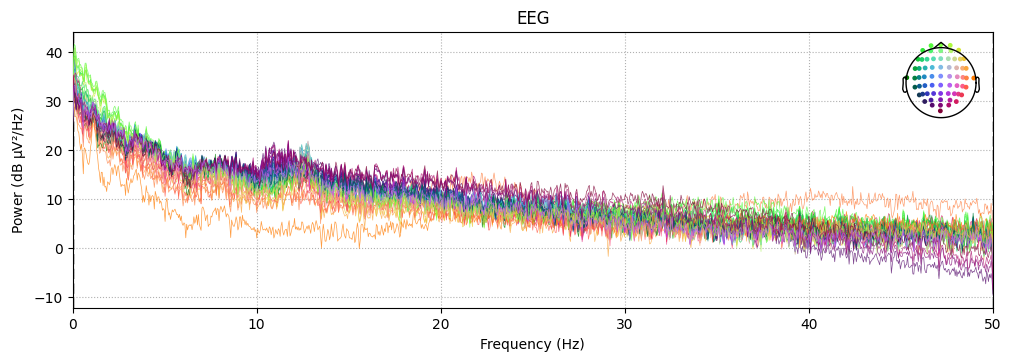

In [6]:
# Set sampling frequency to 100Hz
raw_obj.resample(100, npad="auto")
len(raw_obj)
print(raw_obj.info['sfreq'])
raw_obj.plot_psd()

## Blind Source Separation (BSS)
### Using Independent Component Analysis

Filtering raw data in 3 contiguous segments
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 10 components
Fitting ICA took 0.7s.
Creating RawArray with float64 data, n_channels=10, n_times=37500
    Range : 0 ... 37499 =      0.000 ...   374.990 secs
Ready.
Using matplotlib as 2D backend.


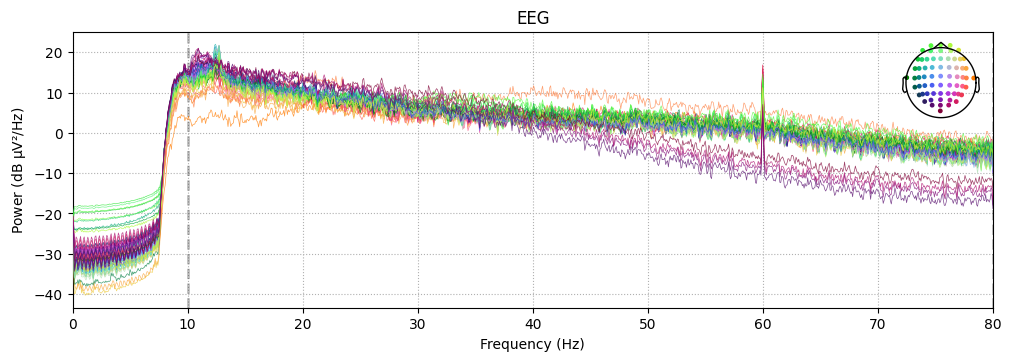

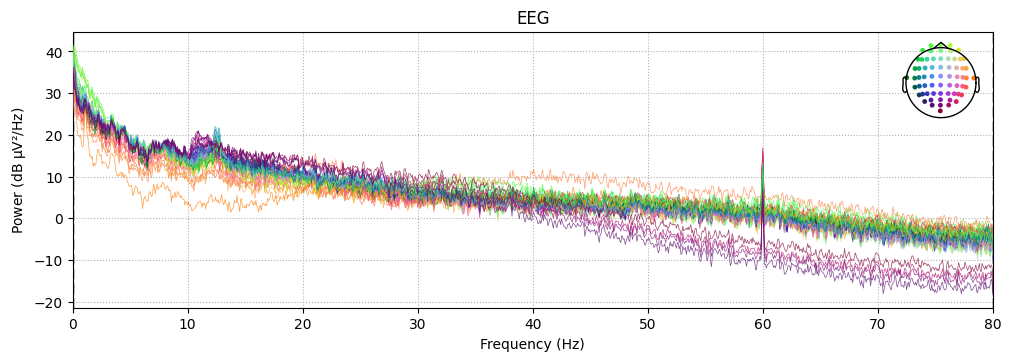

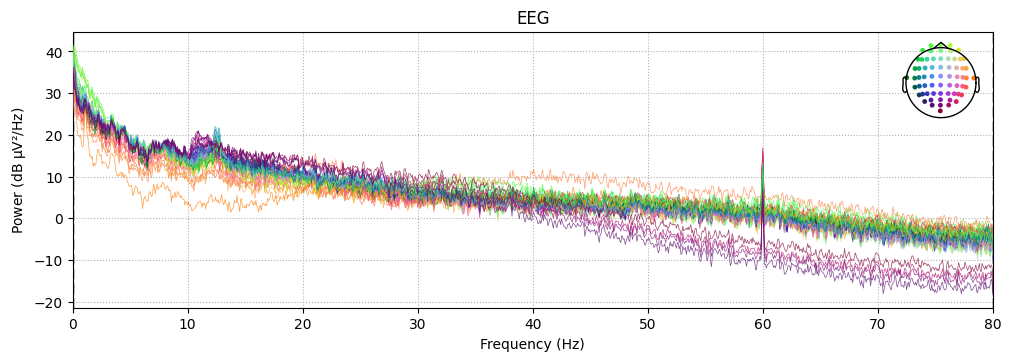

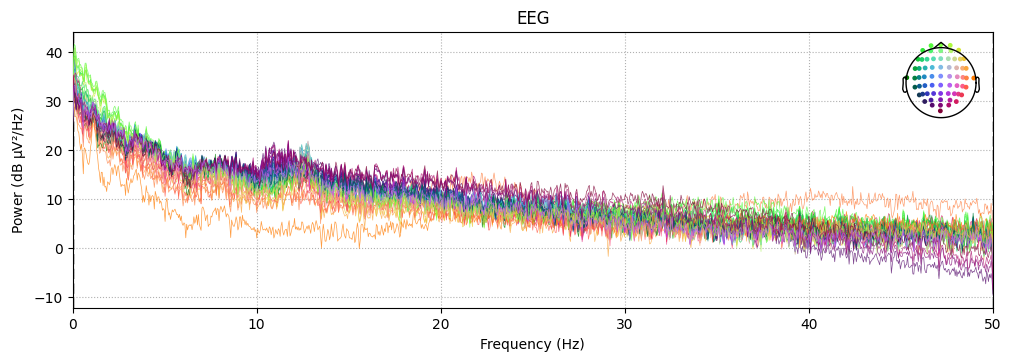

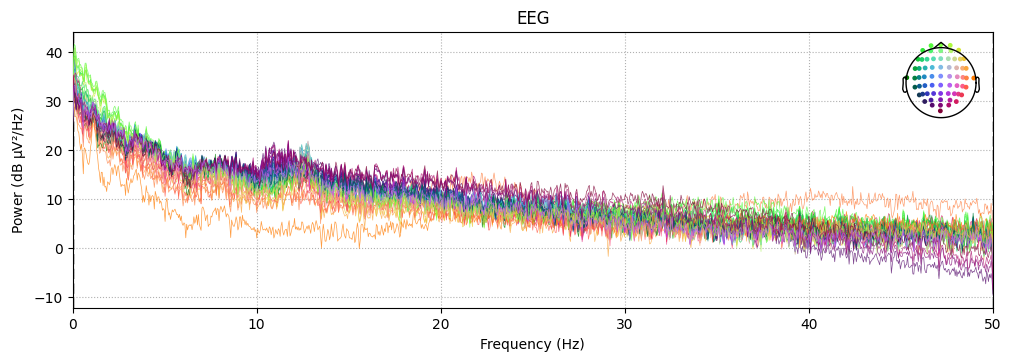

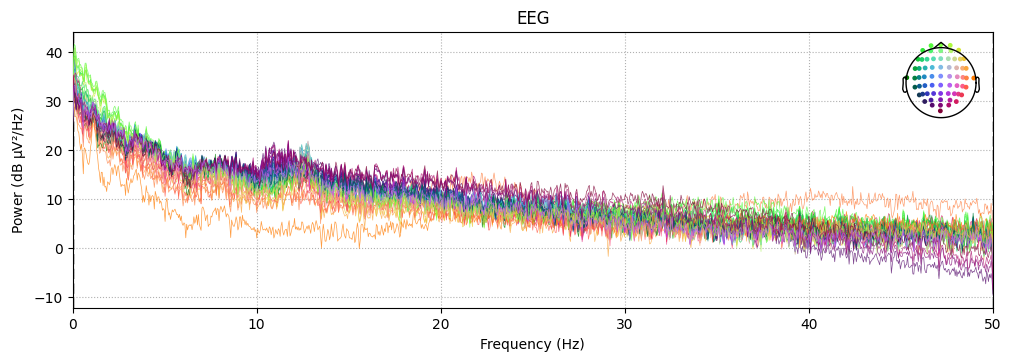

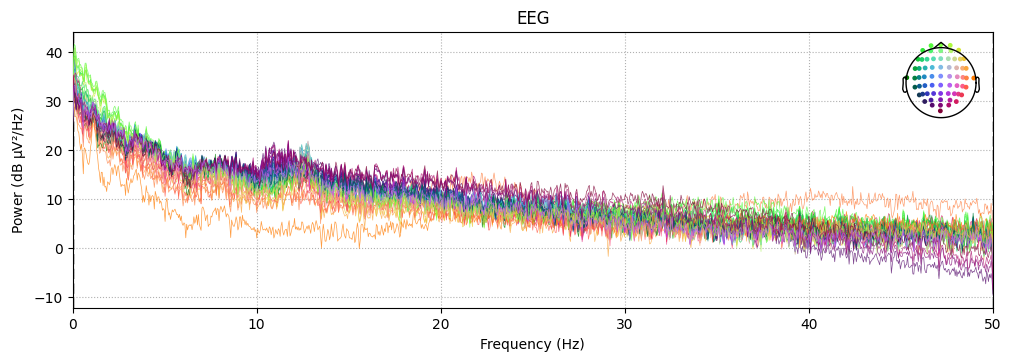

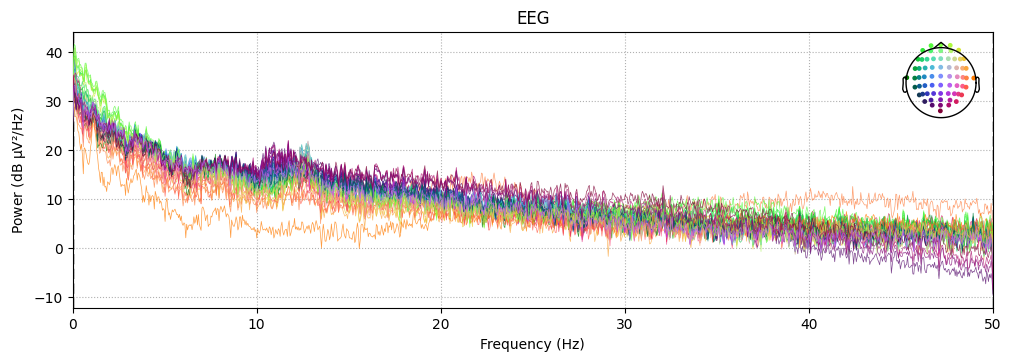

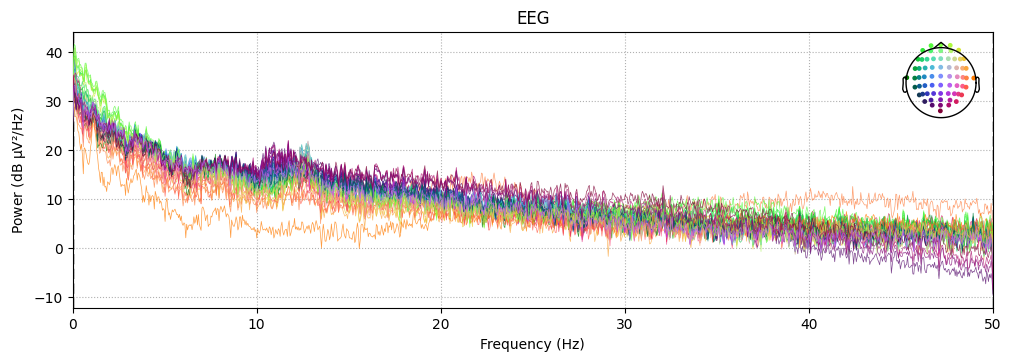

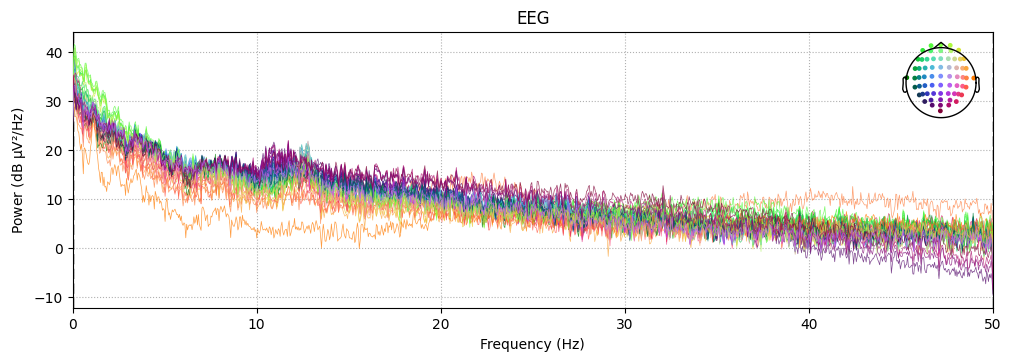

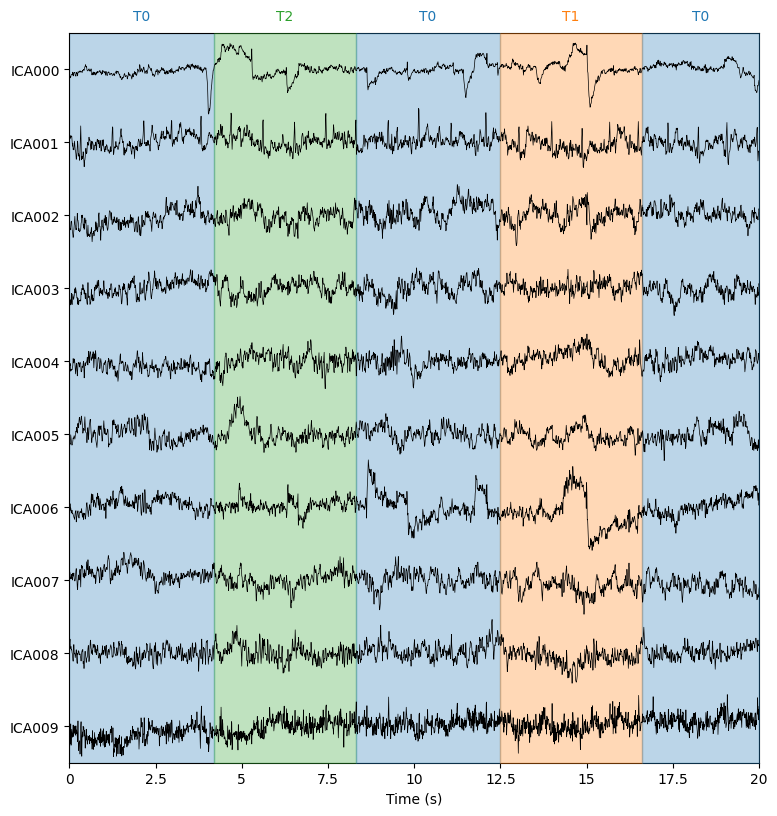

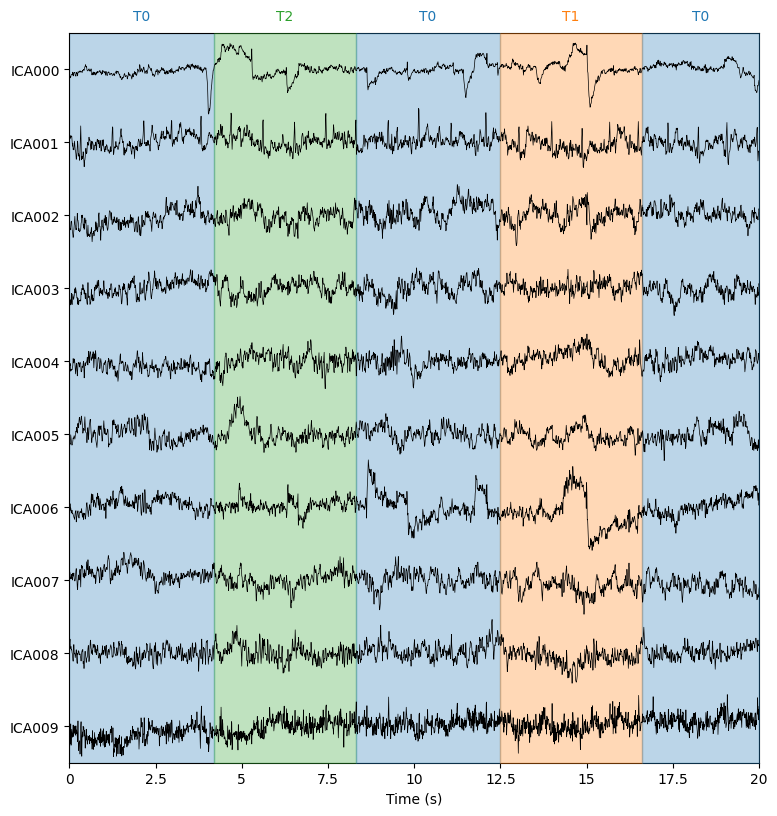

In [10]:
# Apply High Pass Filter
filt_raw = raw_obj.copy().filter(l_freq=1., h_freq=None)
# Apply ICA
ica = mne.preprocessing.ICA(n_components=10)
ica.fit(filt_raw)
# Plot the ICA components against EOG signal.
# See which component matches the EOG signal.
ica.plot_sources(raw_obj, show_scrollbars=False)

## See topographic map of components

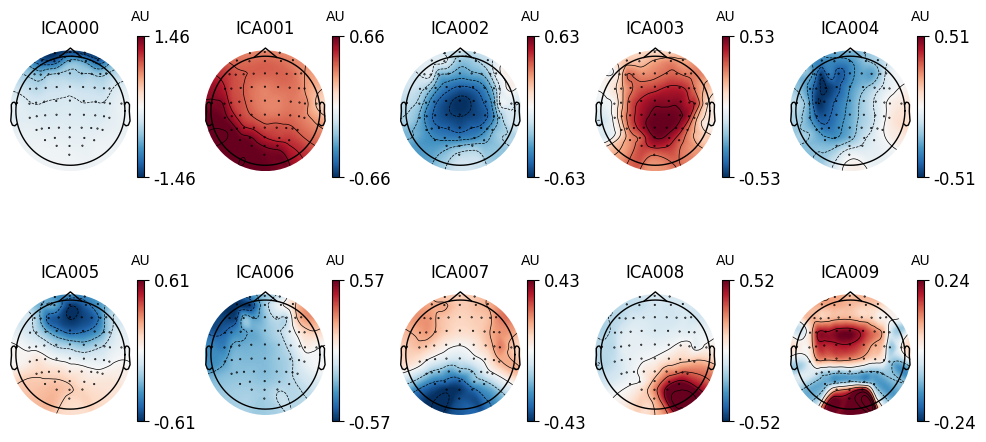

In [12]:
#We could also use the topomaps to identify the noise component.
ica.plot_components(picks=range(10), ch_type='eeg', title='', colorbar=True, show=False)

## Result of combined signal without the component 0

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


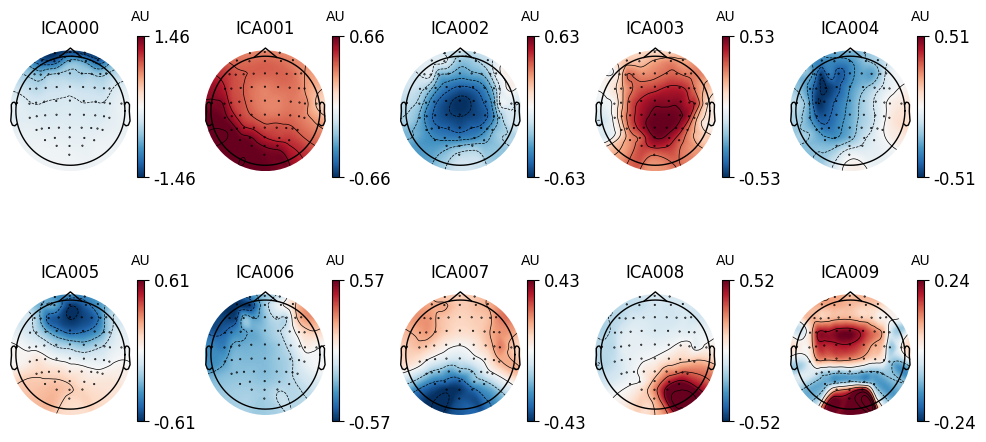

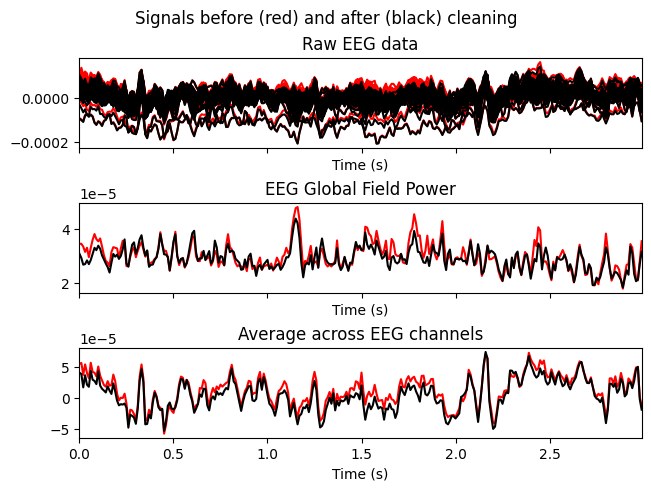

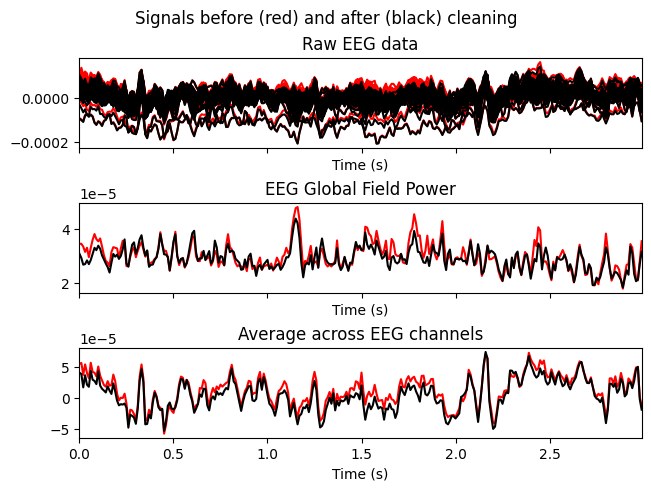

In [13]:
# overlay the reconstructed signal to see how it looks like after reconstruction.
ica.plot_overlay(raw_obj, exclude=[0], picks='eeg')

## Reconstruct the data without component 0

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


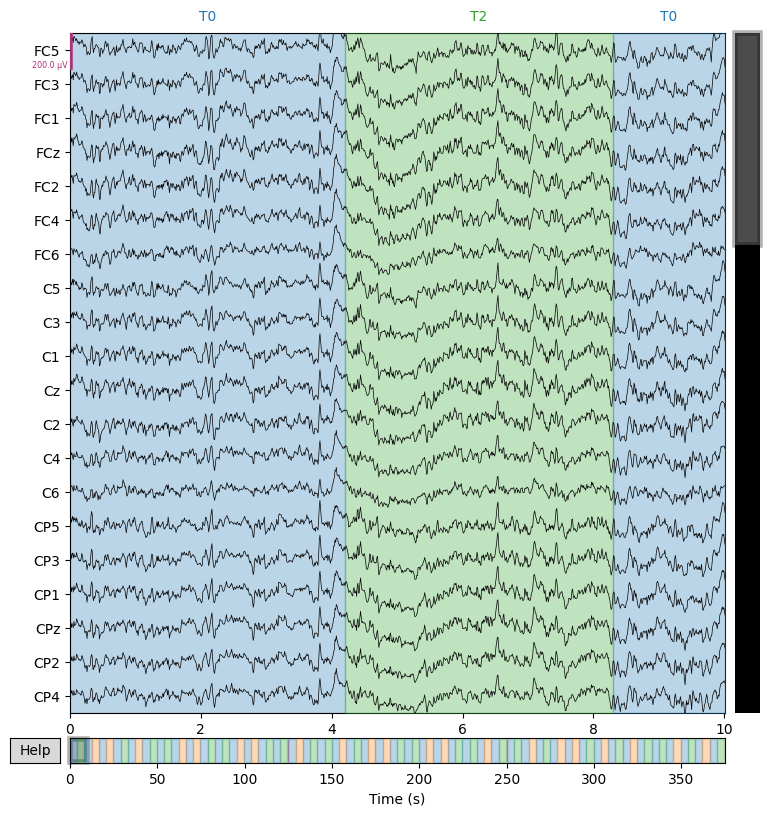

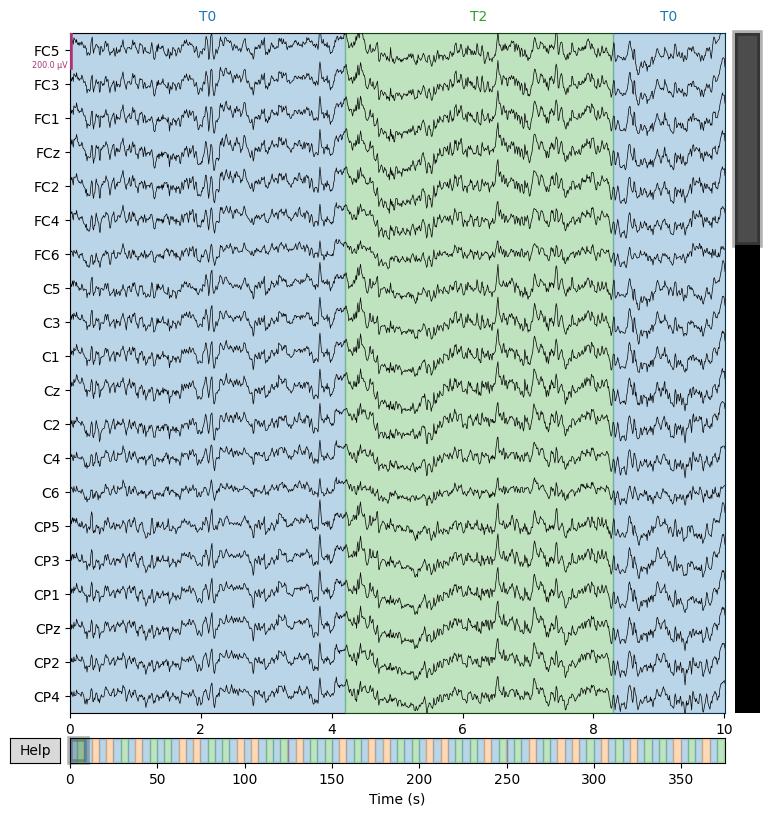

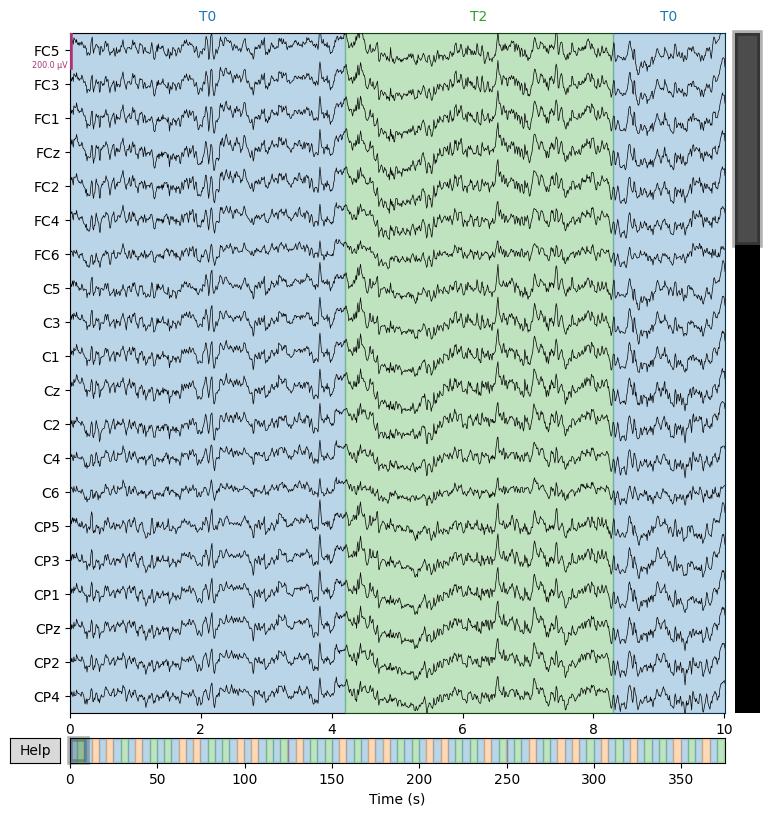

In [14]:
# Once you identified which component to remove.
# You can reconstruct the data as follows:
ica.exclude = [0]
reconst_raw = raw_obj.copy()
ica.apply(reconst_raw)
raw_obj.plot(scalings=0.0001)
reconst_raw.plot(scalings=0.0001)